In [17]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# satss models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#Time aeries analysis -PDMARIMA
import pmdarima
from pmdarima.arima import auto_arima

Reading the cleaed data

In [18]:
paris = pd.read_csv(r'C:\Users\radek\Git-Hub\Final_Project_Ironhack\05 - Time Series\Paris_clean_for_ts.csv')

In [19]:
paris.head()

,datetime,pm25,pm10,o3,no2
0,2014-01-01,43.0,30.0,22.0,42.0
1,2014-01-02,53.0,33.0,22.0,34.0
2,2014-01-03,50.0,28.0,23.0,41.0
3,2014-01-04,52.0,23.0,19.0,34.0
4,2014-01-05,45.0,20.0,20.0,30.0


In [20]:
paris.datetime= pd.to_datetime(paris.datetime)

In [21]:
paris.dtypes

datetime    datetime64[ns]
pm25               float64
pm10               float64
o3                 float64
no2                float64
dtype: object

<AxesSubplot:xlabel='datetime', ylabel='pm25'>

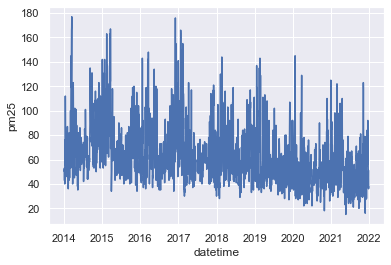

In [22]:
sns.lineplot(x='datetime', y='pm25', data=paris)

<AxesSubplot:xlabel='datetime', ylabel='pm10'>

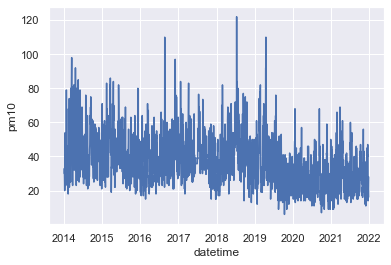

In [23]:
sns.lineplot(x='datetime', y='pm10', data=paris)

<AxesSubplot:xlabel='datetime', ylabel='o3'>

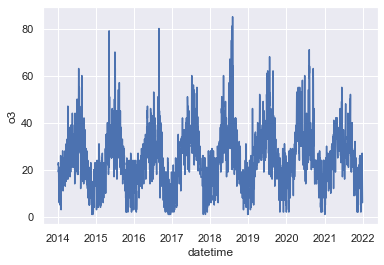

In [24]:
sns.lineplot(x='datetime', y='o3', data=paris)

<AxesSubplot:xlabel='datetime', ylabel='no2'>

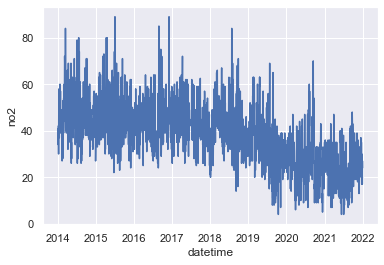

In [25]:
sns.lineplot(x='datetime', y='no2', data=paris)

## PM 2.5

In [26]:
data_pm25=paris.pm25.tolist()

In [27]:
pm25= pd.DataFrame(data_pm25, index=paris.datetime, columns=['pm25'])

In [28]:
pm25

,pm25
datetime,
2014-01-01,43.0
2014-01-02,53.0
2014-01-03,50.0
2014-01-04,52.0
2014-01-05,45.0
...,...
2021-12-27,47.0
2021-12-28,37.0
2021-12-29,38.0


#### Stationarity 

In [29]:
result = adfuller(pm25)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

ADF Test Statistic: -6.23
5% Critical Value: -2.86
p-value: 0.00


In [30]:
output_df = pd.DataFrame({"Values":[result[0],result[1],result[2],result[3], result[4]['1%'], result[4]['5%'], result[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -6.231608e+00              Test Statistics
1  4.937869e-08                      p-value
2  2.200000e+01             No. of lags used
3  2.899000e+03  Number of observations used
4 -3.432608e+00          critical value (1%)
5 -2.862538e+00          critical value (5%)
6 -2.567301e+00         critical value (10%)


Basing on the Dickey - Fuller test I can conclude that the data is stationary as the p-value is below 0.05 

#### Autocorrelation

In [31]:
autocorrelation_lag1 = paris['pm25'].autocorr(lag=1)
print("One Day Lag: ", autocorrelation_lag1)
autocorrelation_lag3 = paris['pm25'].autocorr(lag=3)
print("Three Day Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = paris['pm25'].autocorr(lag=6)
print("Six Day Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = paris['pm25'].autocorr(lag=9)
print("Nine Day Lag: ", autocorrelation_lag9)

One Day Lag:  0.7494992027538105
Three Day Lag:  0.44102496689975346
Six Day Lag:  0.291831481482925
Nine Day Lag:  0.1966319111013463


C:\Users\radek\anaconda3\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


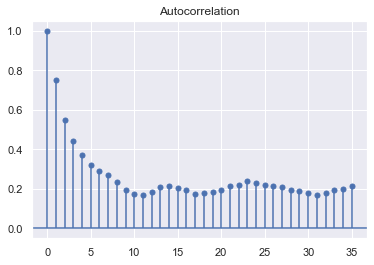

In [32]:
pmdarima.plot_acf(pm25)

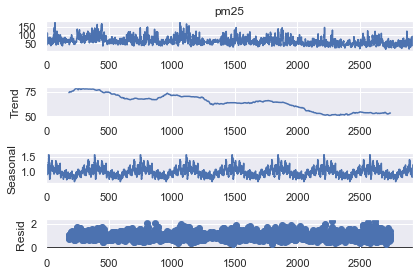

In [33]:
decompose = seasonal_decompose(paris.pm25,model='multiplicative', period=365)
decompose.plot()
plt.show()

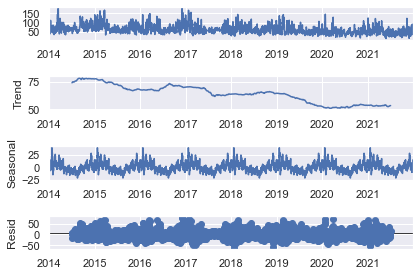

In [34]:
decompose_pm_add = seasonal_decompose(pm25,model='additive', period=365)
decompose_pm_add.plot()
plt.show()

#### Train test split

In [35]:
(pm25.shape[0])*0.8

2337.6

In [36]:
train = pm25[:2338]
test = pm25[2338:]

In [37]:
train

,pm25
datetime,
2014-01-01,43.0
2014-01-02,53.0
2014-01-03,50.0
2014-01-04,52.0
2014-01-05,45.0
...,...
2020-05-22,39.0
2020-05-23,45.0
2020-05-24,43.0


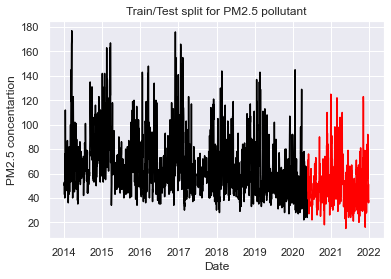

In [38]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for PM2.5 pollutant")
plt.ylabel("PM2.5 concentartion")
plt.xlabel('Date')
sns.set()
plt.show()

### PDMARIMA

In [39]:
model_25 = auto_arima(train.pm25, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=52, n_jobs=-1)
model_25.fit(train.pm25)
forecast_pm25 = model_25.predict(n_periods=len(test))
forecast_pm25 = pd.DataFrame(forecast_pm25,index = test.index,columns=['Prediction'])

C:\Users\radek\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=19278.827, Time=46.76 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=19645.787, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=19627.764, Time=9.92 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=19613.911, Time=6.91 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=19643.788, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=19279.583, Time=44.96 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=19279.198, Time=46.80 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=19279.993, Time=208.10 sec
 ARIMA(2,1,2)(1,0,2)[52] intercept   : AIC=19279.952, Time=208.71 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=19282.721, Time=2.03 sec
 ARIMA(2,1,2)(0,0,2)[52] intercept   : AIC=19277.943, Time=232.70 sec
 ARIMA(1,1,2)(0,0,2)[52] intercept   : AIC=19278.618, Time=175.98 sec
 ARIMA(2,1,1)(0,0,2)[52] intercept   : AIC=19281.292, Time=173.42 sec
 ARIMA(3,1,2)(0,0,2)[52] intercept   : AIC=19277.661, Time=4

MemoryError: Unable to allocate 204. MiB for an array with shape (107, 107, 2338) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1000, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions.MemoryError: Unable to allocate 204. MiB for an array with shape (107, 107, 2338) and data type float64


AttributeError: Memoryview is not initialized

In [ ]:
forecast_pm25.max()

Prediction    55.849646
dtype: float64

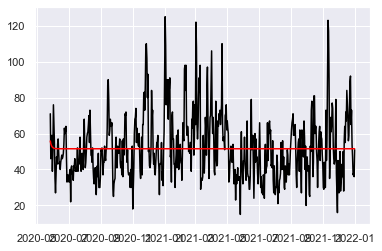

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)

plt.plot(test, color = "black")
plt.plot(forecast_pm25, color = "red")
plt.show()

## PM 10

In [ ]:
data_pm10=paris.pm10.tolist()
pm10= pd.DataFrame(data_pm10, index=paris.datetime, columns=['pm10'])

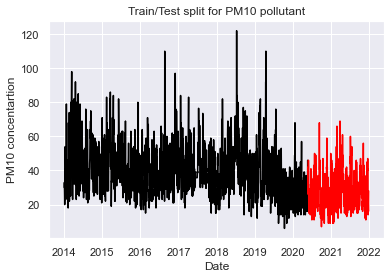

In [ ]:
train = pm10[:2338]
test = pm10[2338:]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for PM10 pollutant")
plt.ylabel("PM10 concentartion")
plt.xlabel('Date')
sns.set()
plt.show()

In [ ]:
model_pm10 = auto_arima(train.pm10, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=52, n_jobs=-1)
model_pm10.fit(train.pm10)
forecast_pm10 = model_pm10.predict(n_periods=len(test))
forecast_pm10 = pd.DataFrame(forecast_pm10,index = test.index,columns=['Prediction'])

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)

plt.plot(test, color = "black")
plt.plot(forecast_pm10, color = "red")
plt.show()

## O3


In [ ]:
data_o3=paris.o3.tolist()
o3= pd.DataFrame(data_o3, index=paris.datetime, columns=['o3'])

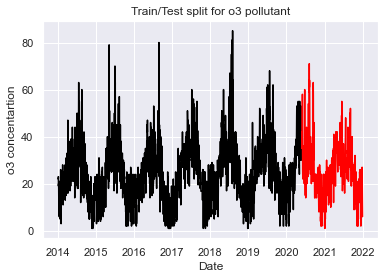

In [ ]:
train = o3[:2338]
test = o3[2338:]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for o3 pollutant")
plt.ylabel("o3 concentartion")
plt.xlabel('Date')
sns.set()
plt.show()

In [ ]:
model_o3 = auto_arima(train.o3, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=52, n_jobs=-1)
model_o3.fit(train.o3)
forecast_o3 = model_o3.predict(n_periods=len(test))
forecast_o3 = pd.DataFrame(forecast_o3,index = test.index,columns=['Prediction'])

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)

plt.plot(test, color = "black")
plt.plot(forecast_o3, color = "red")
plt.show()

## NO2

In [ ]:
data_no2=paris.no2.tolist()
no2= pd.DataFrame(data_no2, index=paris.datetime, columns=['no2'])

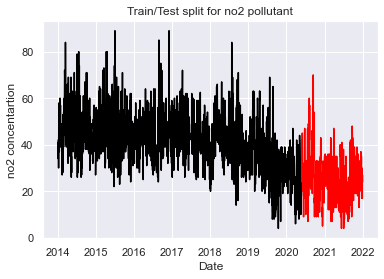

In [ ]:
train = no2[:2338]
test = no2[2338:]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for no2 pollutant")
plt.ylabel("no2 concentartion")
plt.xlabel('Date')
sns.set()
plt.show()

In [ ]:
model_no2 = auto_arima(train.no2, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=52, n_jobs=-1)
model_no2.fit(train.no2)
forecast_no2 = model_no2.predict(n_periods=len(test))
forecast_no2 = pd.DataFrame(forecast_no2,index = test.index,columns=['Prediction'])

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)

plt.plot(test, color = "black")
plt.plot(forecast_no2, color = "red")
plt.show()